# SYSID - Trabalho (ML - MIMO.02)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#MO
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor, SYSIDRandomizedSearchCV

# Modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score



#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/data/volve_compiled.pkl


In [3]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


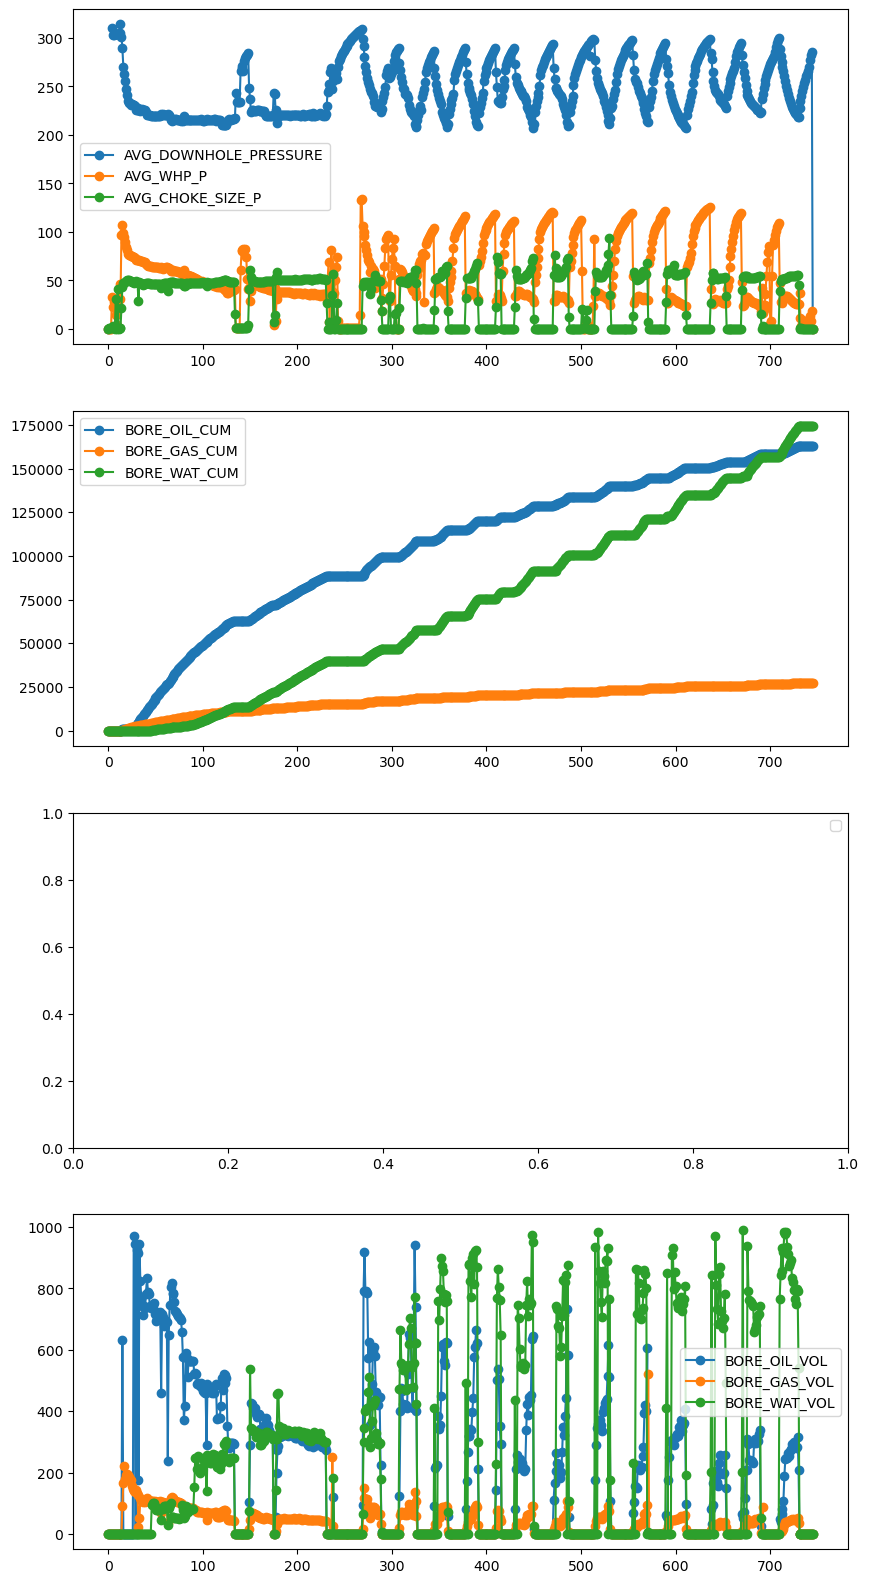

In [4]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        'BORE_GAS_CUM',
        'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        #'AVG_WHT_P',
        #'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        'BORE_OIL_VOL',
        #'BORE_LIQ_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [5]:
data_case = data_case.loc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [6]:
p_train = 0.8 #80% treino

### 1.2 - Separando os conjuntos

In [7]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

In [8]:
print(
    X1_tr.shape,
    X1_te.shape
)

(574, 6) (144, 6)


In [9]:
print(
    y_tr.shape,
    y_te.shape
)

(574, 3) (144, 3)


In [10]:
y_scale = MinMaxScaler()
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

In [11]:
models = [
    ('LinReg',  LinearRegression(copy_X=True)),
    ('SVM',     SVR(max_iter=-1)),
    ('KNN',     KNeighborsRegressor()),
    ('DT',      DecisionTreeRegressor(random_state=rs)),
    ('RF',      RandomForestRegressor(random_state=rs)),
]

n_models = len(models)

In [12]:
parameters = [
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'positive'            : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
]

In [13]:
#t_tr = np.arange(570)
#tmax = np.max(t_tr)
#nfolds = 3
#rkf = [
#    ((t_tr <= tmax/3),(tmax/3 < t_tr)&(t_tr <= 2*tmax/3),),
#    ((tmax/3 < t_tr)&(t_tr <= 2*tmax/3),(2*tmax/3 < t_tr),),
#]
kfolds = 5
niters = 50
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [14]:
results = {
    'MODEL':[],
    'R2 TRAIN':[],
    'R2 TEST':[],
    'MODEL OBJ':[],
    #'PARS':[]
}

Iniciando avaliação do modelo: LinReg


/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



    Tempo de execução: 0:00:02.813853
    Minimum  error: -0.6535780376203401
    Maximum  error: 0.6112761485168186
    R2 score (Train): 0.31968701794106724 0.21695882603272743 0.24949414625595157
    R2 score (Test): -1.1018969590713552 -1.0300048949525884 0.3095005517896472

Iniciando avaliação do modelo: SVM

    Tempo de execução: 0:07:02.517286
    Minimum  error: -0.5986321614432404
    Maximum  error: 0.8185059437289454
    R2 score (Train): 0.6867634639237848 0.2986401470239022 0.5379672797556115
    R2 score (Test): 0.49187433023207905 -4.566740800948291 0.5883273576170811

Iniciando avaliação do modelo: KNN

    Tempo de execução: 0:00:45.710811
    Minimum  error: -0.8185889201141792
    Maximum  error: 0.9027989720581643
    R2 score (Train): 0.233087326604819 0.17338837167068843 -0.29408868310280023
    R2 score (Test): -1.561180421379766 -0.8329074471914186 -0.4648677419597802

Iniciando avaliação do modelo: DT

    Tempo de execução: 0:00:32.454505
    Minimum  error:

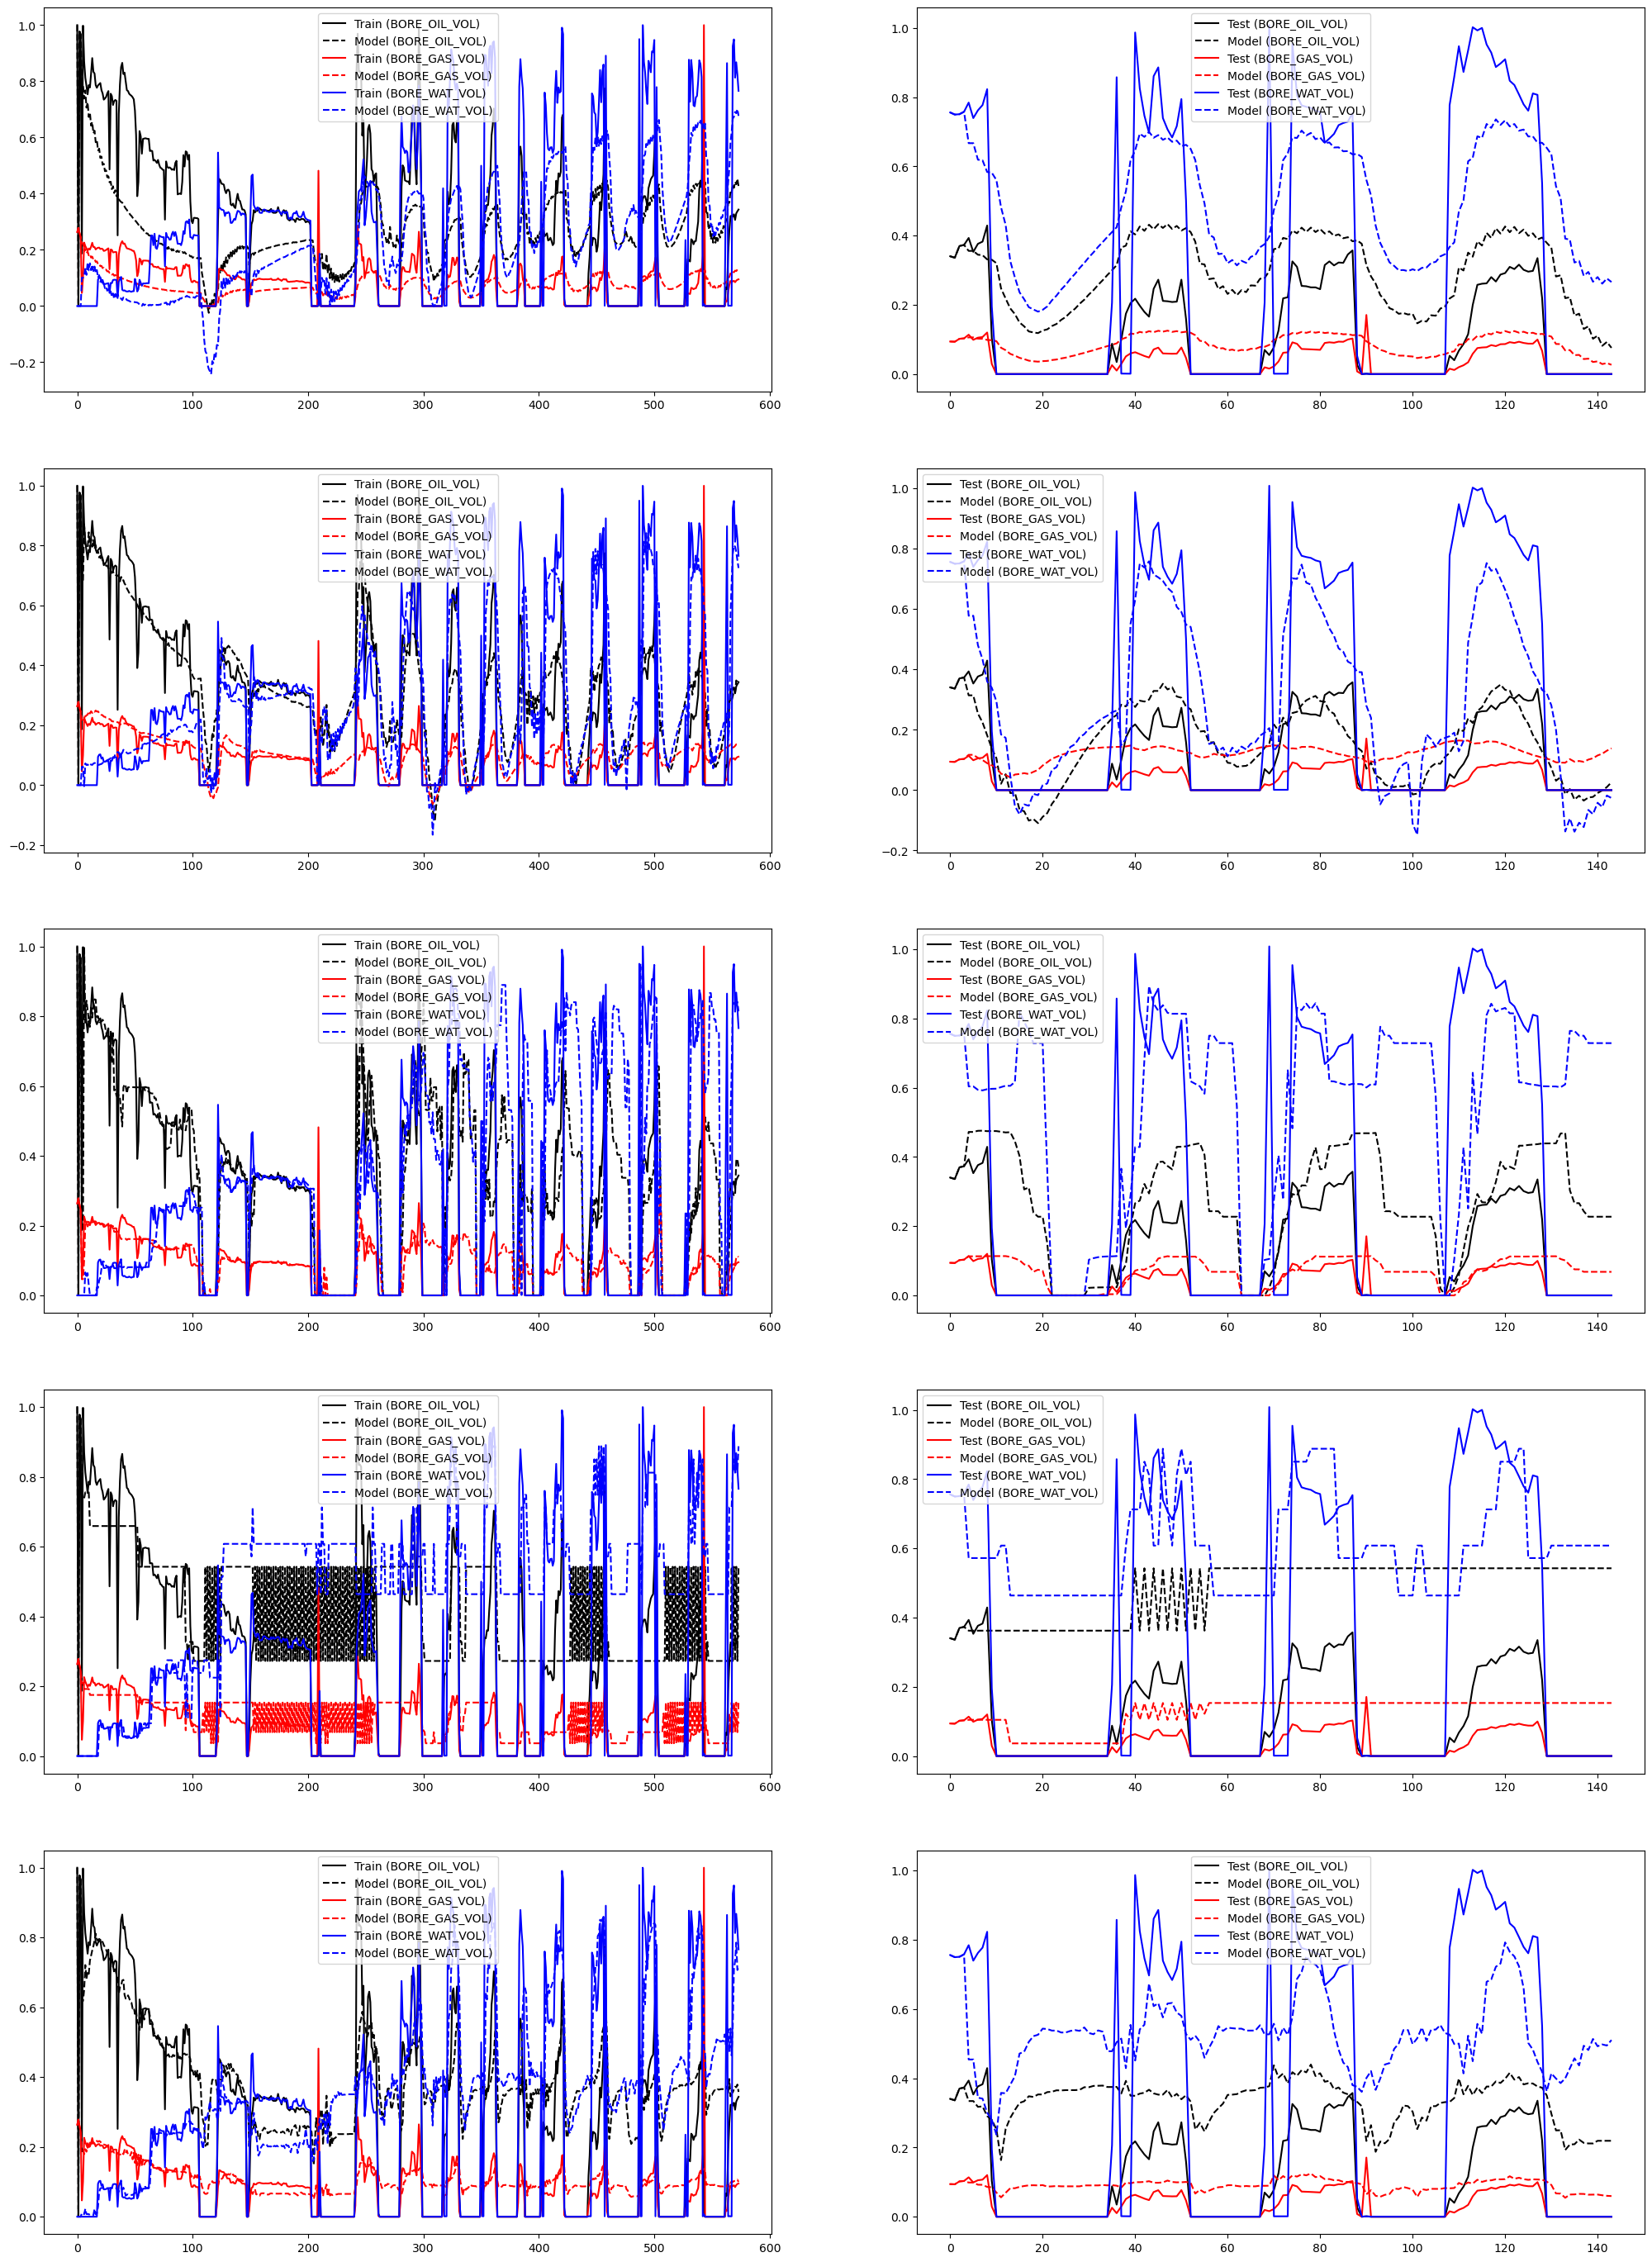

In [15]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    model_bin = model[1]
    print('Iniciando avaliação do modelo: {}'.format(model_name))

    rdmsearch = RandomizedSearchCV(model_bin, verbose=0, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)

    MOreg = RegressorChain(rdmsearch, order=[0, 2, 1])
    
    sidmodel = SYSIDRegressor(
        nX=4, ny=4,
        estimator=MOreg, 
        preprocessor=MinMaxScaler(),
        expansor=PolynomialFeatures(degree=1)
        )
    
    t0 = datetime.now()
    
    #
        
    sidmodel.fit(X1_tr, y_tr)
    
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    error = (y_te - sidmodel.predict(X1_te, y=y_te))
    print('    Minimum  error:', error.min())
    print('    Maximum  error:', error.max())
    r2_tr = [r2_score(y_tr[:,i], sidmodel.predict(X1_tr, y=y_tr)[:,i]) for i in range(len(filt_vars_OUT))]
    r2_te = [r2_score(y_te[:,i], sidmodel.predict(X1_te, y=y_te)[:,i]) for i in range(len(filt_vars_OUT))]
    print('    R2 score (Train):', *r2_tr)
    print('    R2 score (Test):', *r2_te)
    

    # PLOTANDO
    color = ['k', 'r', 'b']
    ind = [0, 1, 2]
    for i, c, var in zip(ind, color, filt_vars_OUT):

        hist = ax[0].plot(y_tr[:,i], c, label=f'Train ({var})')
        hist = ax[0].plot(sidmodel.predict(X1_tr, y=y_tr)[:,i], c+'--', label=f'Model ({var})')
        hist = ax[1].plot(y_te[:,i], c, label=f'Test ({var})')
        hist = ax[1].plot(sidmodel.predict(X1_te, y=y_te)[:,i], c+'--', label=f'Model ({var})')
    
    ax[0].legend()
    ax[1].legend()
    print()
    for i in ind:
        results['MODEL'].append(f'{model_name}_{i}')
        results['R2 TRAIN'].append(r2_tr[i])
        results['R2 TEST'].append(r2_te[i])
        results['MODEL OBJ'].append(sidmodel)
    

In [16]:
pd.DataFrame(results)

,MODEL,R2 TRAIN,R2 TEST,MODEL OBJ
0,LinReg_0,0.319687,-1.101897,SYSIDRegressor(estimator=RegressorChain(base_e...
1,LinReg_1,0.216959,-1.030005,SYSIDRegressor(estimator=RegressorChain(base_e...
2,LinReg_2,0.249494,0.309501,SYSIDRegressor(estimator=RegressorChain(base_e...
3,SVM_0,0.686763,0.491874,SYSIDRegressor(estimator=RegressorChain(base_e...
4,SVM_1,0.298640,-4.566741,SYSIDRegressor(estimator=RegressorChain(base_e...
5,SVM_2,0.537967,0.588327,SYSIDRegressor(estimator=RegressorChain(base_e...
6,KNN_0,0.233087,-1.561180,SYSIDRegressor(estimator=RegressorChain(base_e...
7,KNN_1,0.173388,-0.832907,SYSIDRegressor(estimator=RegressorChain(base_e...
8,KNN_2,-0.294089,-0.464868,SYSIDRegressor(estimator=RegressorChain(base_e...
9,DT_0,-0.062314,-7.456427,SYSIDRegressor(estimator=RegressorChain(base_e...
